# Ocean Two EDA and Time Series for Occupancy, Revenue and Average rate

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import itertools
plt.style.use('fivethirtyeight') 

%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from fbprophet import Prophet
import math
from sklearn.metrics import mean_squared_error
from random import random
from math import sqrt

In [2]:
df = pd.read_excel('concat_raw_o2.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 11 columns):
DATE         1642 non-null object
IND REV      1642 non-null float64
IND RM       1642 non-null int64
GROUP REV    1642 non-null float64
GROUP RM     1642 non-null int64
ALLOT REV    1642 non-null float64
ALLOT RM     1642 non-null int64
REVENUE      1642 non-null float64
RM OCC       1642 non-null int64
AVE RATE     1642 non-null float64
OCC %        1642 non-null float64
dtypes: float64(6), int64(4), object(1)
memory usage: 141.2+ KB


In [4]:
df[['DATE', 'DAY_OF_WEEK']] = df['DATE'].str.split(' ', n=1, expand=True)
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

print('Time period start: {}\nTime period end: {}'.format(df.DATE.min(),df.DATE.max()))

Time period start: 2016-01-01 00:00:00
Time period end: 2019-12-31 00:00:00


Cut out the data after 2019-08-04. Remove two data points with negaitve revenue. And remove duplicates.

In [6]:
df.set_index('DATE', inplace=True)
df = df['2016-01-01':'2019-08-04']
df = df.loc[df['IND REV'] >=0]
df = df.loc[~df.index.duplicated(keep='first')]

## Occupancy, Revenue and Average rate distribution

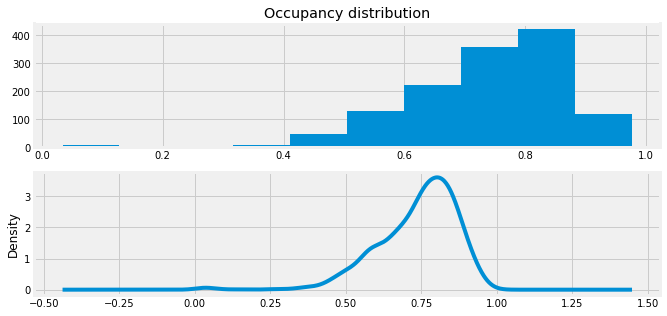

In [20]:
plt.figure(1)
plt.subplot(211)
df['OCC %'].hist(figsize=(10,5))
plt.title('Occupancy distribution')
plt.subplot(212)
df['OCC %'].plot(kind='kde')
plt.show();

* The distribution of occupancy is not a normal distribution.

* The distribution is right shifted.

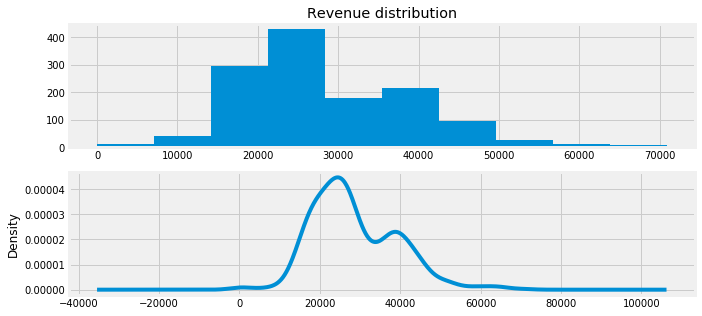

In [21]:
plt.figure(1)
plt.subplot(211)
df['REVENUE'].hist(figsize=(10,5))
plt.title('Revenue distribution')
plt.subplot(212)
df['REVENUE'].plot(kind='kde')
plt.show();

* The distribution is not perfect gaussian, but its pretty close.

## Average Rate distribution

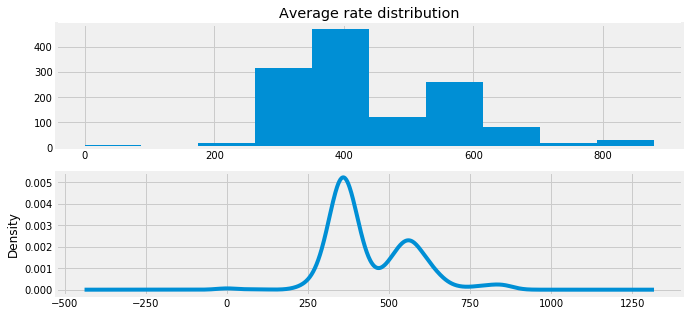

In [22]:
plt.figure(1)
plt.subplot(211)
df['AVE RATE'].hist(figsize=(10,5))
plt.title('Average rate distribution')
plt.subplot(212)
df['AVE RATE'].plot(kind='kde')
plt.show();

* This reflects the room types of the hotels. The room types at around 300 to 400 average rate are the majority,followed by around 500 to 600 average rate. 

## Boxplot

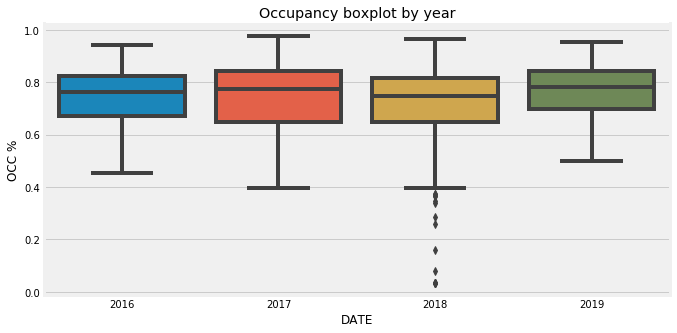

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.year, df['OCC %'], ax=ax)
plt.title('Occupancy boxplot by year');

* I'm not sure 2019's occupancy is a complete picture, because we still have 4 more months to go, and not hurriance season yet.

* The occupancy median values across years does not show an upwards trend.

* 2018 had the most number of outliers, as we will see later.

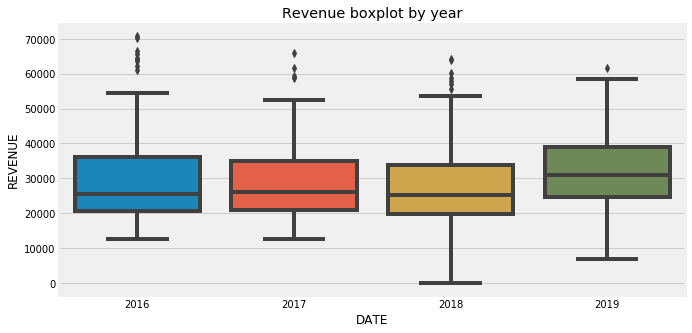

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.year, df['REVENUE'], ax=ax)
plt.title('Revenue boxplot by year');

* Same thing here, there were no upward trend in median revenue and 2019 was not a complete picture.

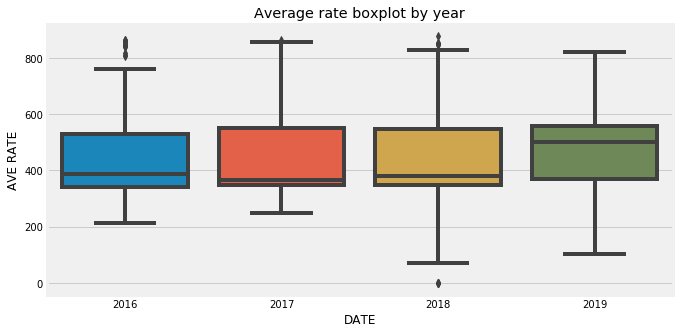

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.year, df['AVE RATE'], ax=ax)
plt.title('Average rate boxplot by year');

* 2017 posted the lowest median average rate. Besides, the median rate does not change much across the year.

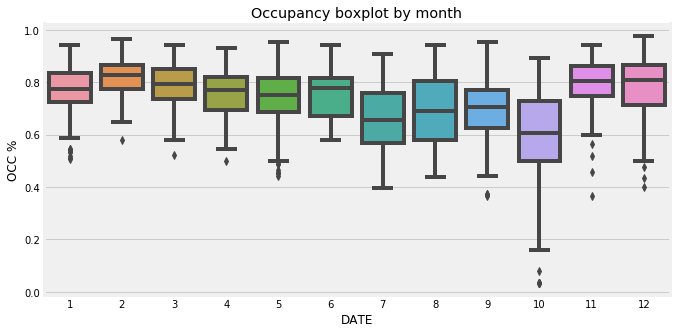

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.month, df['OCC %'], ax=ax)
plt.title('Occupancy boxplot by month');

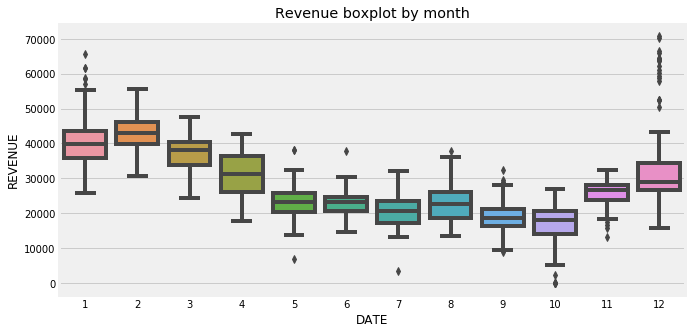

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.month, df['REVENUE'], ax=ax)
plt.title('Revenue boxplot by month');

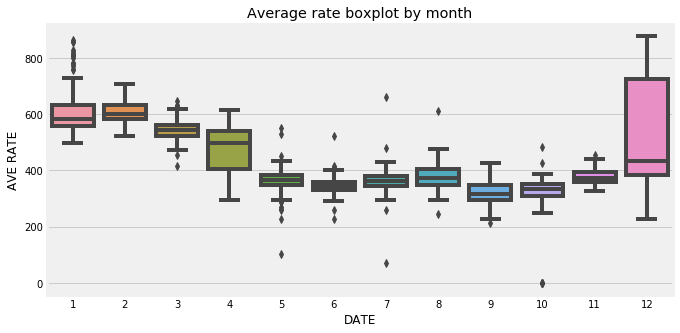

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.index.month, df['AVE RATE'], ax=ax)
plt.title('Average rate boxplot by month');

The above three box plots by month share the similar trends. We observed: 

* October is the worst month in terms occupancy and revenue. I guess it is because of hurricane.

* October is not the worst in terms of average rate. It makes sense, if there is hurricane, tourists will not come no matter how cheap the rooms are.

* In terms of occupancy, the best months of the year are February, November and December. In terms of revenue and average rate, the best months are January and February. This indicates that the hotel sells the rooms at a lower price in the months immediately after hurricane.  

* The conclusion of hurricane season means tourists will start returning to the region, meaning rates will steadily increase until reaches its peak in February.

* The occupancy throughout the year is more steadier than the rate. Meaning in order to maintain a higher occupancy, the hotel would sacrifice rate when it needs to.

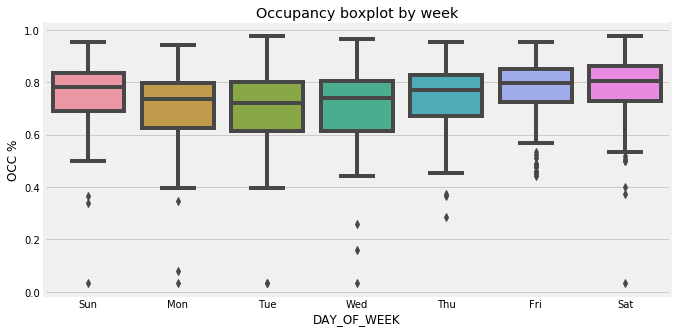

In [36]:
order = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df['DAY_OF_WEEK'], df['OCC %'], ax=ax, order=order)
plt.title('Occupancy boxplot by week');

In general, median occupancy is higher during the weekend (Fri, Sat and Sun) than during the weekdays.

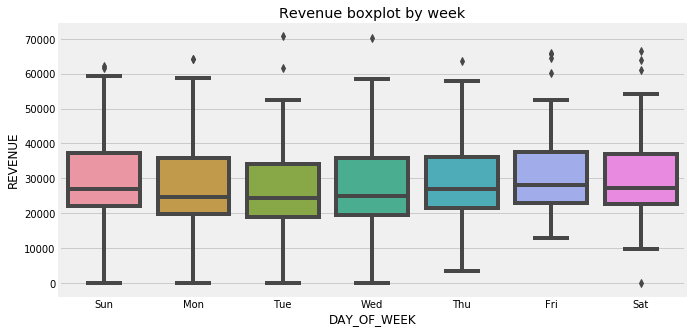

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df['DAY_OF_WEEK'], df['REVENUE'], ax=ax, order=order)
plt.title('Revenue boxplot by week');

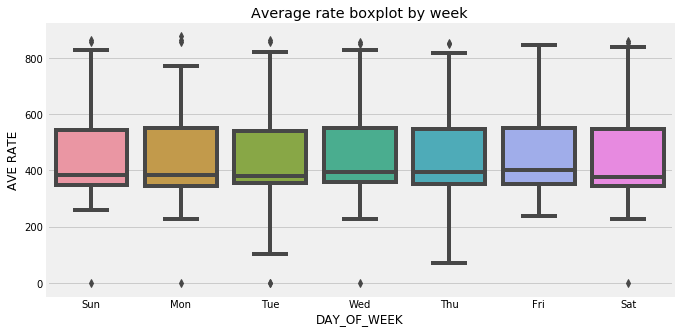

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df['DAY_OF_WEEK'], df['AVE RATE'], ax=ax, order=order)
plt.title('Average rate boxplot by week');

The daily median average rate and median revenue do not vary much throughout the week.

## Time Series

## At this time, we care about occupancy revenue and average rate, let's focus on them.

The following three plots show occupancy revenue and average rate trends during 2016 through 2019. They do not reveal a general upward trend or downward trend. However, they do reveal some what seasonality trend.

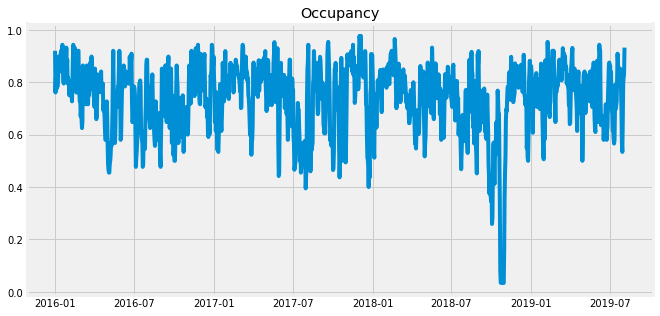

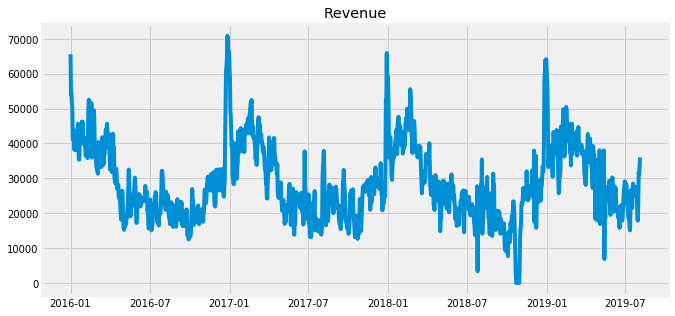

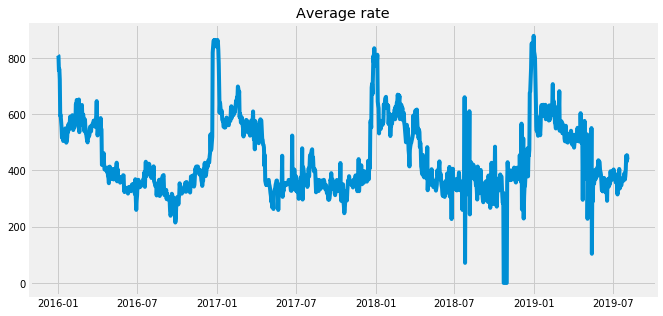

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(df['OCC %'])
plt.title('Occupancy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df['REVENUE'])
plt.title('Revenue')
plt.grid(True)
plt.show();

plt.figure(figsize=(10, 5))
plt.plot(df['AVE RATE'])
plt.title('Average rate')
plt.grid(True)
plt.show();

Something happened towards the end of 2018, let me zoom in.

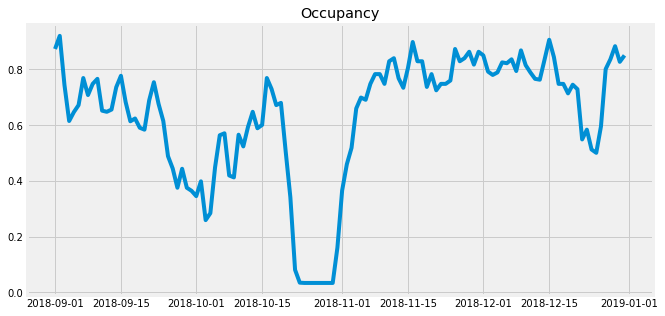

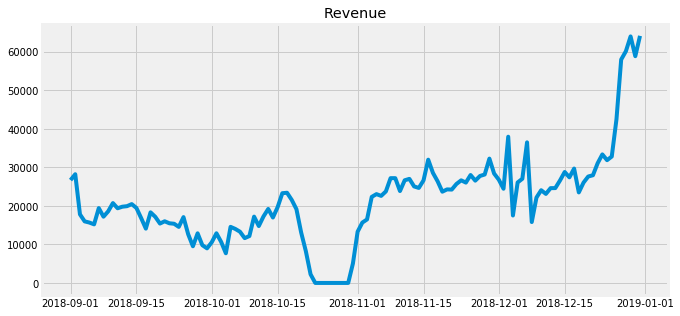

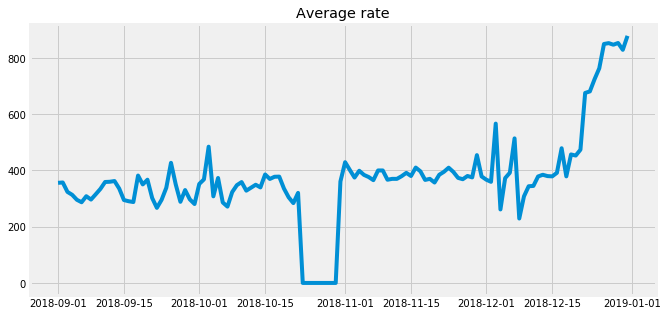

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(df['2018-09-01':'2018-12-31']['OCC %'])
plt.title('Occupancy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df['2018-09-01':'2018-12-31']['REVENUE'])
plt.title('Revenue')
plt.grid(True)
plt.show();

plt.figure(figsize=(10, 5))
plt.plot(df['2018-09-01':'2018-12-31']['AVE RATE'])
plt.title('Average rate')
plt.grid(True)
plt.show();

For 6 days in Oct 2018, there was zero revenue. Was the hotel closed because of hurricane or small remodeling?

In [41]:
df['2018-10-22':'2018-11-01']

,IND REV,IND RM,GROUP REV,GROUP RM,ALLOT REV,ALLOT RM,REVENUE,RM OCC,AVE RATE,OCC %,DAY_OF_WEEK
DATE,,,,,,,,,,,
2018-10-22,1499.95,5,0.00,0,741.44,2,2241.39,7,320.20,0.081,Mon
2018-10-23,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.035,Tue
2018-10-24,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.034,Wed
2018-10-27,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.034,Sat
2018-10-28,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.034,Sun
2018-10-29,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.034,Mon
2018-10-30,0.00,3,0.00,0,0.00,0,0.00,3,0.00,0.034,Tue
2018-10-31,3481.43,10,876.26,2,693.03,2,5050.72,14,360.77,0.161,Wed
2018-11-01,10973.51,26,876.26,2,1458.66,3,13308.43,31,429.30,0.365,Thu


## Shifting and lags on occupancy, revenue and average rate

We can shift index by let's say 10 months periods with a month frequency. So that we can compare the time series with a past of itself.

In [42]:
pd.plotting.register_matplotlib_converters()

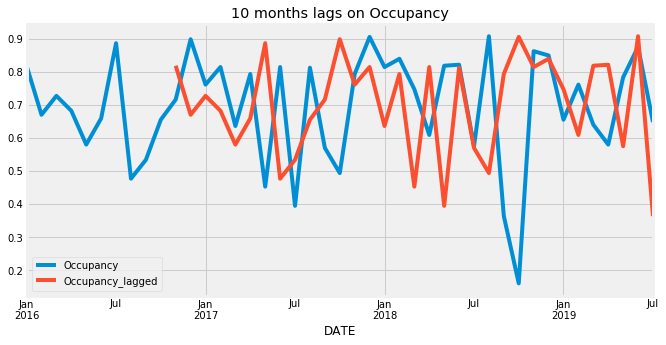

In [43]:
df["OCC %"].asfreq('M').plot(legend=True, figsize=(10, 5))
shifted = df["OCC %"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Occupancy','Occupancy_lagged'])
plt.title('10 months lags on Occupancy')
plt.show();

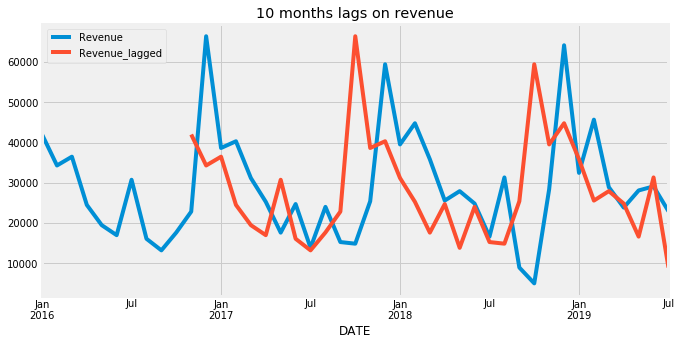

In [44]:
df["REVENUE"].asfreq('M').plot(legend=True, figsize=(10, 5))
shifted = df["REVENUE"].asfreq('M').shift(10).plot(legend=True, figsize=(10,5))
shifted.legend(['Revenue','Revenue_lagged'])
plt.title('10 months lags on revenue')
plt.show();

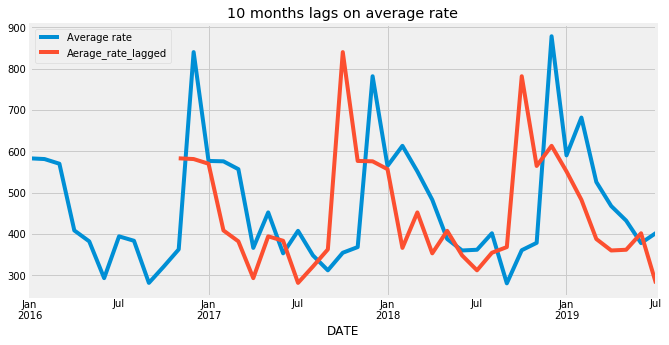

In [45]:
df["AVE RATE"].asfreq('M').plot(legend=True, figsize=(10,5))
shifted = df["AVE RATE"].asfreq('M').shift(10).plot(legend=True, figsize=(10,5))
shifted.legend(['Average rate','Aerage_rate_lagged'])
plt.title('10 months lags on average rate')
plt.show();

## Percent change on Occupancy

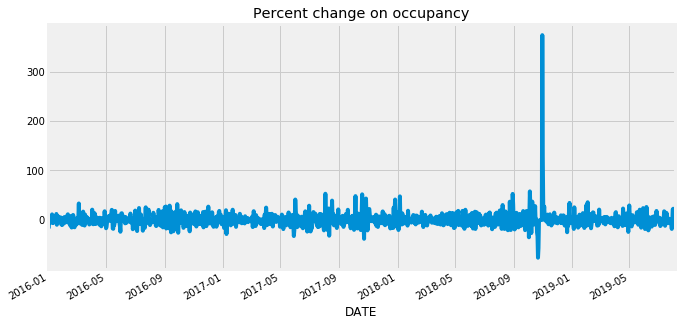

In [46]:
df['OCC %'].pct_change().mul(100).plot(figsize=(10,5))
plt.title('Percent change on occupancy');

There is one big outlier sticking out there, and we know why.

## Moving average

The purpose of using moving average is that when we analyze time series data, we want to smooth out short-term fluctuations and highlight longer-term trends or cycles. The parameters of the moving average shall be set accordingly, and I set 30 days here.

We plot a rolling mean of 30 day window with the occupancy.

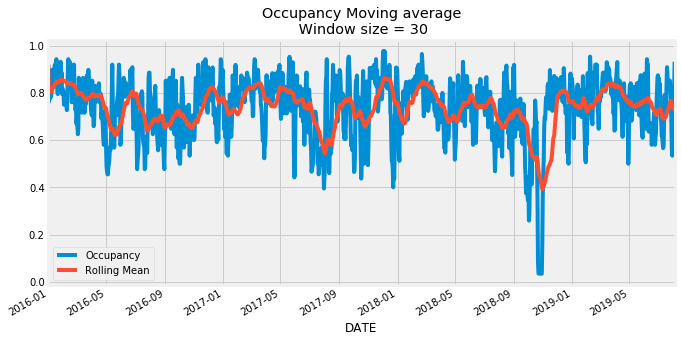

In [47]:
rolling_occ = df['OCC %'].rolling('30D').mean()
df['OCC %'].plot(figsize=(10,5))
rolling_occ.plot(figsize=(10,5))
plt.legend(['Occupancy','Rolling Mean'])
plt.title('Occupancy Moving average\n Window size = 30')
plt.show();

Smoothing by 30 days,  we get monthly trend on occupancy.

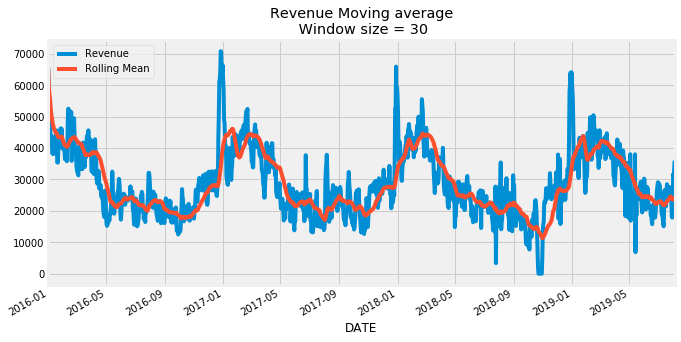

In [48]:
rolling_rev = df['REVENUE'].rolling('30D').mean()
df['REVENUE'].plot(figsize=(10,5))
rolling_rev.plot(figsize=(10,5))
plt.legend(['Revenue','Rolling Mean'])
plt.title('Revenue Moving average\n Window size = 30')
plt.show();

Smoothing by 30 days, we get monthly trend on revenue.

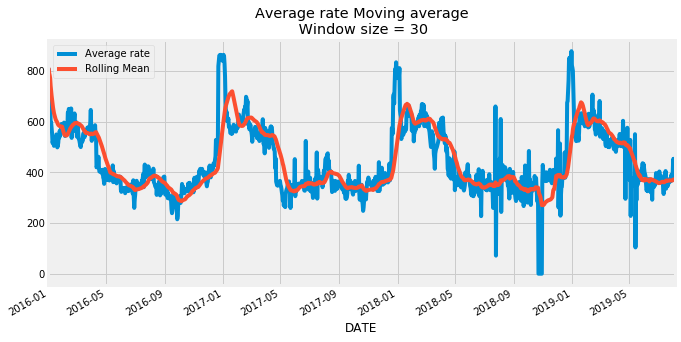

In [49]:
rolling_ave = df['AVE RATE'].rolling('30D').mean()
df['AVE RATE'].plot(figsize=(10,5))
rolling_ave.plot(figsize=(10,5))
plt.legend(['Average rate','Rolling Mean'])
plt.title('Average rate Moving average\n Window size = 30')
plt.show();

Smoothing by 30 days, we get monthly trend on average rate.

We can observe that rolling mean plot is a smoother version of the original plot. Trends and seasonality are easier to spot now. Because it smoothed by the previous month (30 days). Notice how the 30-day trend show a seasonality in revenue and average rate. This might mean that the revenue and average rate are likely to follow the same patterns in the future.

## Time series trend and seasonality

We use decomposition as a primary tool for time series analysis, because it provides a structured way of thinking about a time series forecasting problem. As you can see, each of the following components are something we may need to think about and address during the analysis. 

### Occupancy

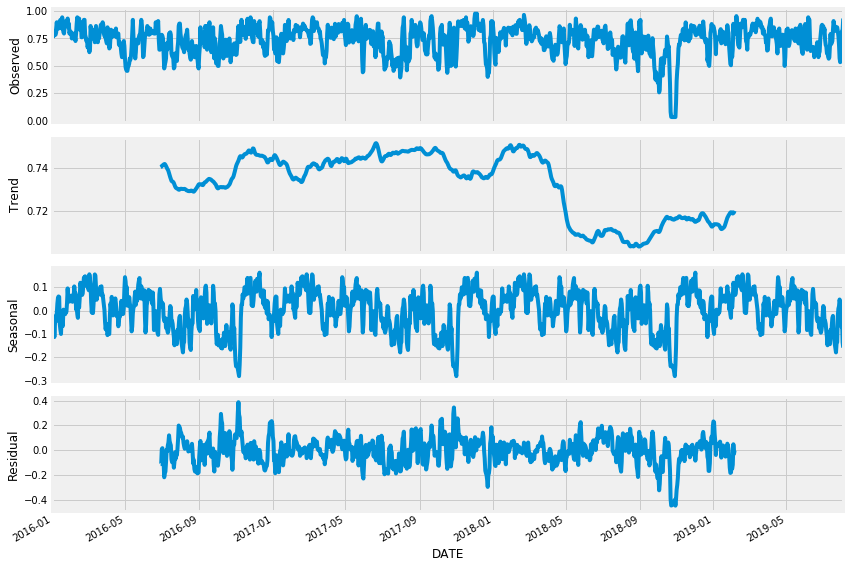

In [50]:
rcParams['figure.figsize'] = 12, 8
decomposed_occ = sm.tsa.seasonal_decompose(df["OCC %"], model='additive', freq=360) # The frequncy is annual
figure = decomposed_occ.plot()
plt.show();

### Observations:

* The occupancy was steady and following a certain pattern until around 2018-05, then it dropped significantly, and it had not climbed back to the previous level yet.

* There are uniform seasonal changes, such as around Oct occupancy are low. From totally barbados website, I read this: "September and October tend to be the most humid months in Barbados, also when there is the highest risk of hurricanes", that's why. And around December is the peak season or high season in Barbados, so the hotel is busier prior to the end of the year.

* Residual represents outliers and missing values. It is showing periods of high variability around Oct in 2016 and 2017, and the end of 2017. And the highest variability occured around Oct 2018 and we know why.

### Revenue

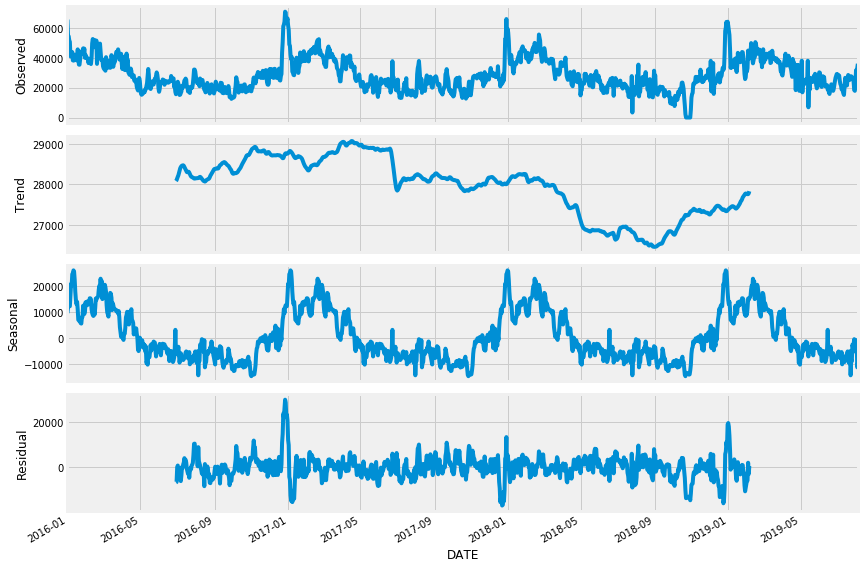

In [53]:
rcParams['figure.figsize'] = 12, 8
decomposed_rev = sm.tsa.seasonal_decompose(df['REVENUE'], model='additive', freq=360)
figure = decomposed_rev.plot()
plt.show();

### Observations:

* Similar with the occupancy decomposition plot, we observed a downward trend in revenue. However, it looks like the revenue is on its way up.

* The seasonality and residual in revenue are more obvious.

### Average rate

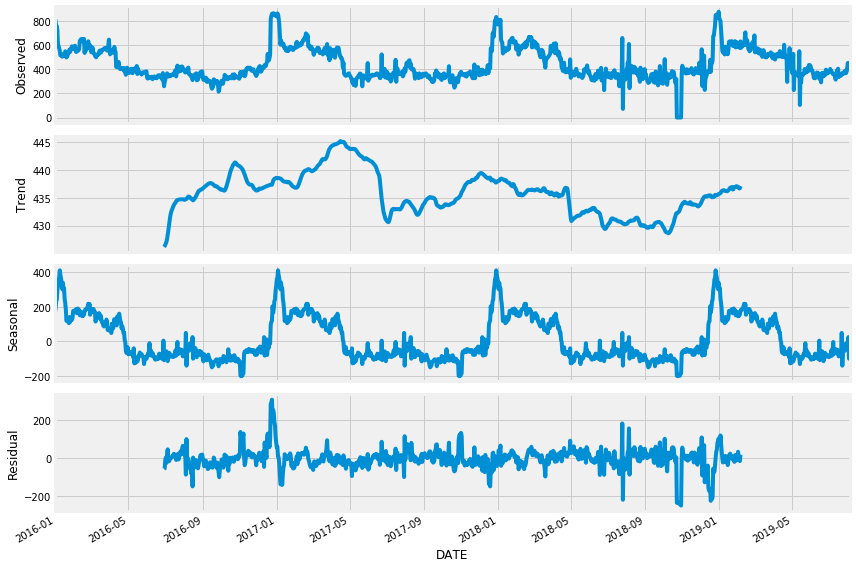

In [55]:
rcParams['figure.figsize'] = 12, 8
decomposed_ave = sm.tsa.seasonal_decompose(df['AVE RATE'], model='additive', freq=360)
figure = decomposed_ave.plot()
plt.show();

With no surprise that average rate decomposition plot shows similar trends and patterns with revenue decomposition plot.

## Quarterly

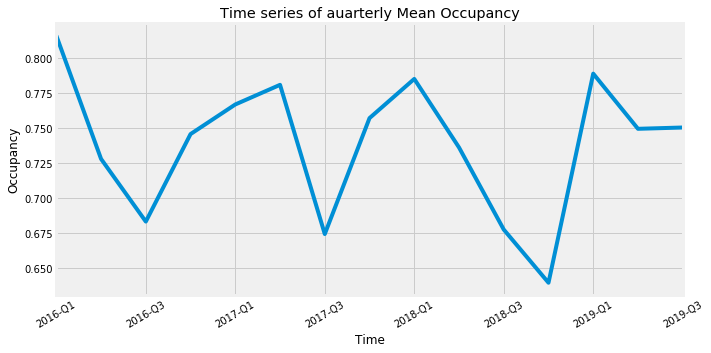

In [56]:
df.reset_index(level=0, inplace=True)
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
month_quarter_map = {1: 'Q1', 2: 'Q1', 3: 'Q1',
                     4: 'Q2', 5: 'Q2', 6: 'Q2',
                     7: 'Q3', 8: 'Q3', 9: 'Q3',
                     10: 'Q4', 11: 'Q4', 12: 'Q4'
                    }
df['quarter'] = df['month'].map(lambda m: month_quarter_map.get(m))
seasonal_sub_series_data = df.groupby(by=['year', 'quarter'])['OCC %', 'REVENUE', 'AVE RATE'].aggregate([np.mean])
seasonal_sub_series_data.columns = ['quarterly_mean_occ', 'quarterly_mean_rev', 'quarterly_mean_ave']
seasonal_sub_series_data.reset_index(inplace=True)
seasonal_sub_series_data.index = seasonal_sub_series_data['year'].astype(str) + '-' + seasonal_sub_series_data['quarter']

plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_occ'].plot()
plt.title('Time series of auarterly Mean Occupancy')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.xticks(rotation=30);

The quarterly time series of occupancy reveals somewhat trend and seasonality, such that the hotel has to overcome the lowest occupany at around Q3 and Q4 every year. And the hotel enjoys the highest occupancy at around Q1 and Q2 every year.

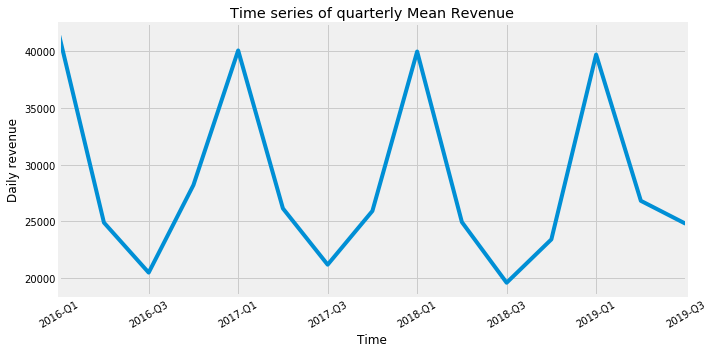

In [59]:
plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_rev'].plot()
plt.title('Time series of quarterly Mean Revenue')
plt.xlabel('Time')
plt.ylabel('Daily revenue')
plt.xticks(rotation=30);

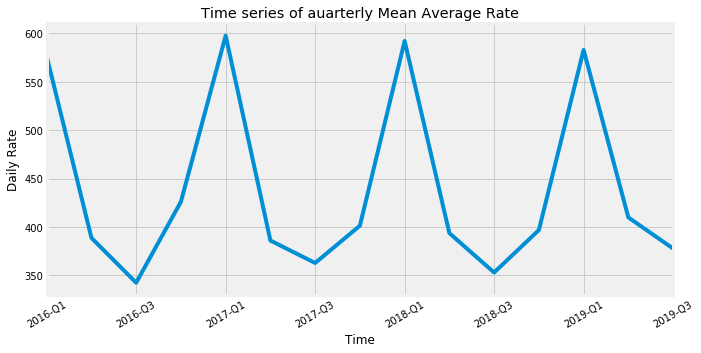

In [60]:
plt.figure(figsize=(10, 5))
seasonal_sub_series_data['quarterly_mean_ave'].plot()
plt.title('Time series of auarterly Mean Average Rate')
plt.xlabel('Time')
plt.ylabel('Daily Rate')
plt.xticks(rotation=30);

The quarterly average revenue and rate time series share the identical strong trends and patterns as they should. The Q1 posts stronger daily revenue and rate and Q3 posts a weak daily revenue and rate. 

A couple of interesting observations: 

* Around 2017-Q2 had one of the highest occupancy, however, during the same time period, the hotel does not have the highest revenue or rate. This confirms our previous assumption that the hotel sometimes has to slash rate to sell more rooms.

* Around 2018-Q4 had the lowest occupancy while the rate and revenue was not the worst. This affected by 6 days zero occupancy in Oct 2018.

* If you remember, when we look at the monthly boxplot, we see Oct is the worst month, when we look at quarterly plot, we realize that Q3 is the worst performed quarter. This indicates that the hotel business recovers quickly after the hurricane season.

## Monthly

The monthly aggregates occupancy, revenue and average rate are plotted in the following figures, which highlights the month wise seasonality.

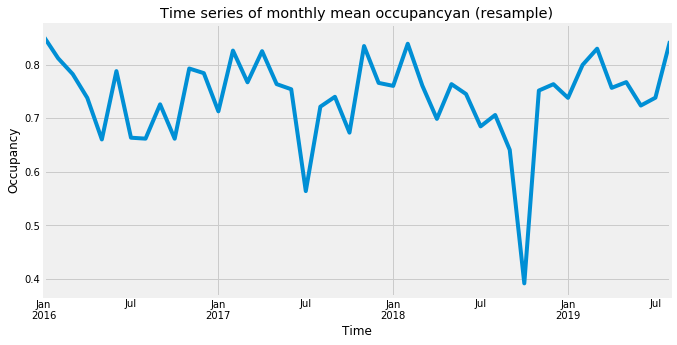

In [61]:
df.set_index('DATE', inplace=True)
plt.figure(figsize=(10, 5))
monthly_mean['OCC %'].plot()
plt.title('Time series of monthly mean occupancyan (resample)')
plt.xlabel('Time')
plt.ylabel('Occupancy');

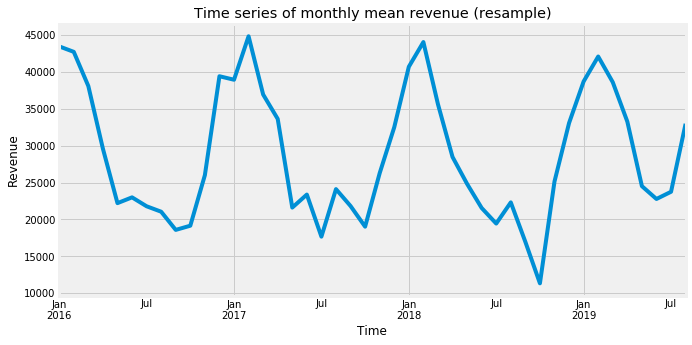

In [62]:
plt.figure(figsize=(10, 5))
monthly_mean['REVENUE'].plot()
plt.title('Time series of monthly mean revenue (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

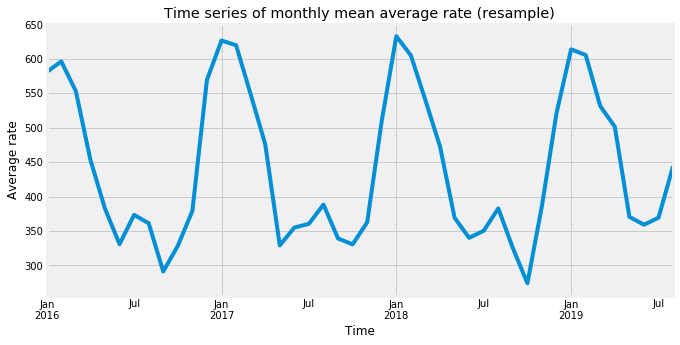

In [63]:
plt.figure(figsize=(10, 5))
monthly_mean['AVE RATE'].plot()
plt.title('Time series of monthly mean average rate (resample)')
plt.xlabel('Time')
plt.ylabel('Average rate');

Observations: 

* During the past 4 years, October 2018 posted the worst occupancy, revenue and average rate, and we know why. 

* July 2017 posted the 2nd worst occupancy and revenue. This is interesting because July 2016 and 2018 were not the worst in term of occupancy , although the average rate in summers months were low.

* The highest occupancy happened around the end of the year and beginning of the following year, while the highest average rate and revenue always occur at the beginning of the year.

## Weekly

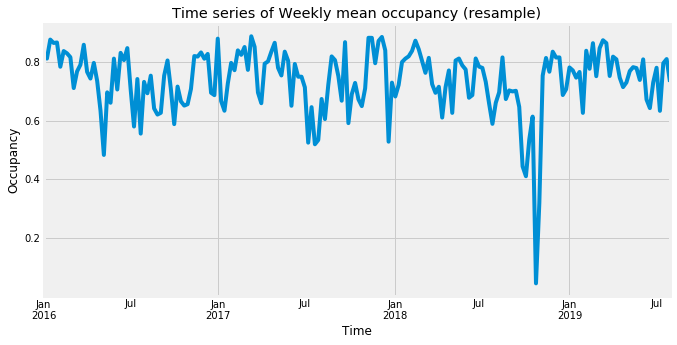

In [64]:
# Resample to monthly frequency, aggregating with mean
weekly_mean = df[data_columns].resample('W').mean()
plt.figure(figsize=(10, 5))
weekly_mean['OCC %'].plot()
plt.title('Time series of Weekly mean occupancy (resample)')
plt.xlabel('Time')
plt.ylabel('Occupancy');

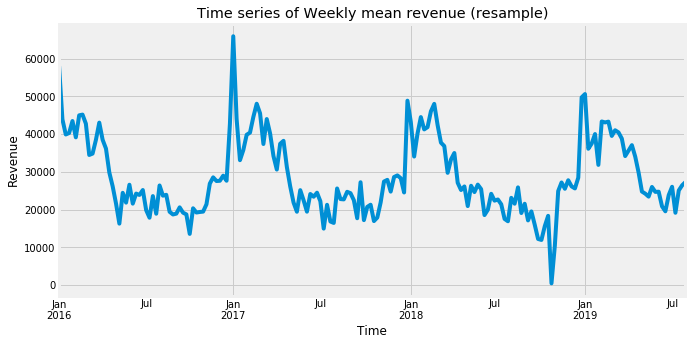

In [65]:
plt.figure(figsize=(10, 5))
weekly_mean['REVENUE'].plot()
plt.title('Time series of Weekly mean revenue (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

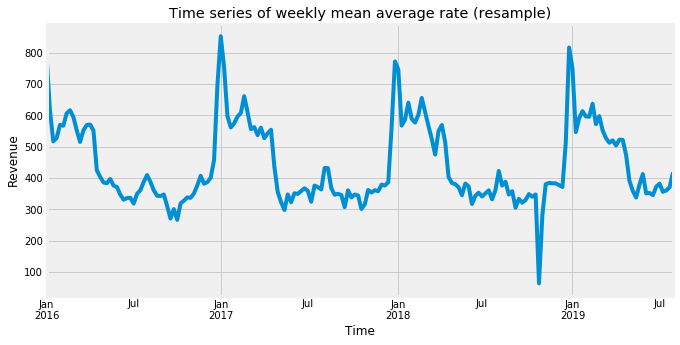

In [66]:
plt.figure(figsize=(10, 5))
weekly_mean['AVE RATE'].plot()
plt.title('Time series of weekly mean average rate (resample)')
plt.xlabel('Time')
plt.ylabel('Revenue');

We can see that the weekly mean time series is smoother than the daily time series, and monthly mean time series is smoother than the weekly time series, and quarterly mean time series is smoother than the monthly time series. Because higher frequency variability has been averaged out in the resampling.

## Pivot table

Using pivot table to analyze and compare by year.

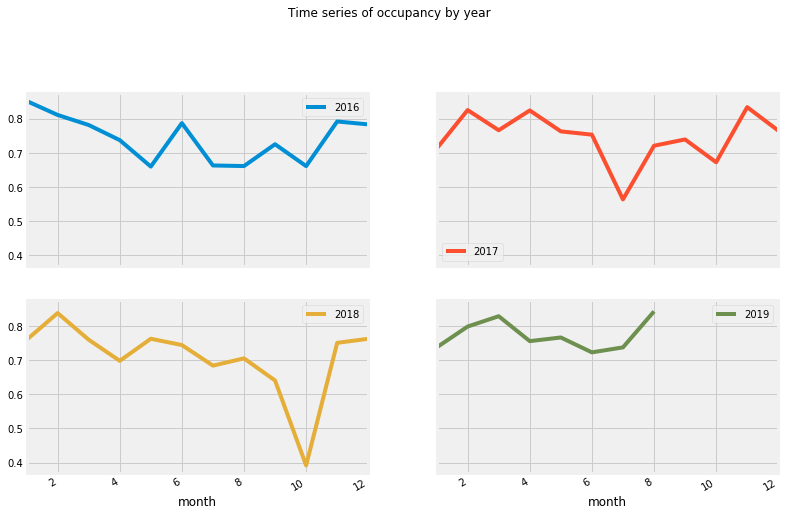

In [67]:
df_pivot = pd.pivot_table(df, values = "OCC %", columns = "year", index = "month")
df_pivot.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of occupancy by year');

In terms of occupancy, Of course, hurricane season has not come yet, but if we only compare Junuary to August for 4 years, 2019 has been doing well so far.

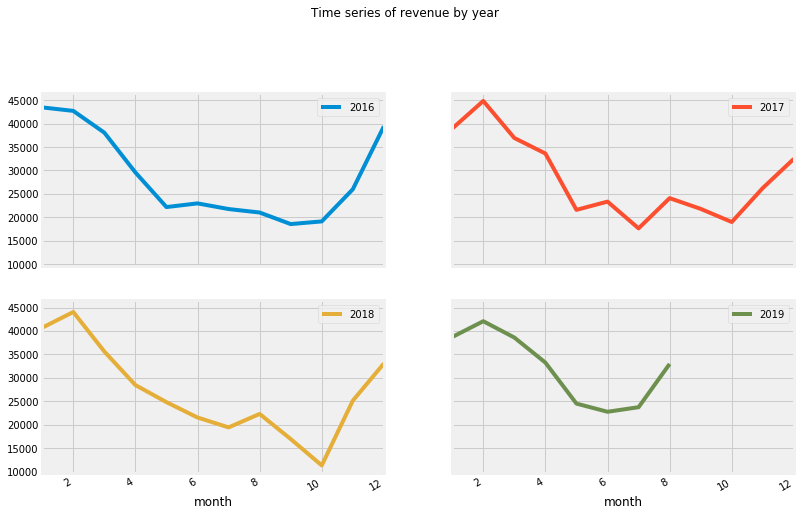

In [68]:
df_pivot1 = pd.pivot_table(df, values = "REVENUE", columns = "year", index = "month")
df_pivot1.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of revenue by year');

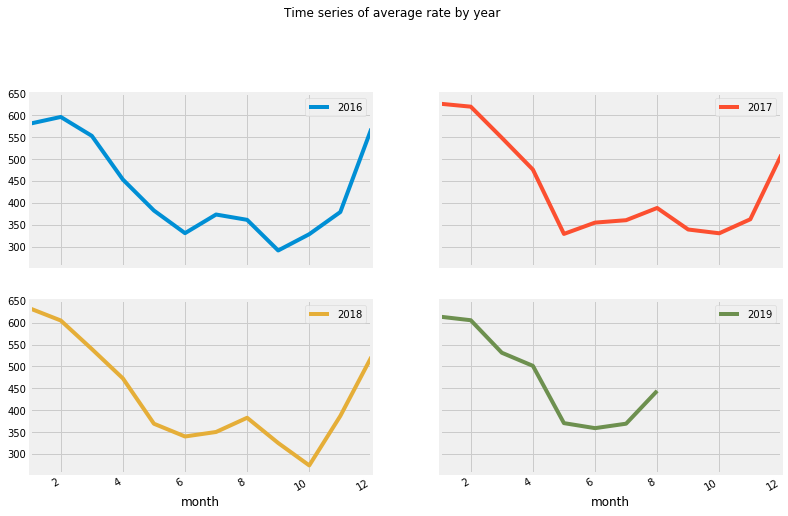

In [69]:
df_pivot2 = pd.pivot_table(df, values = "AVE RATE", columns = "year", index = "month")
df_pivot2.plot(subplots = True, figsize=(12, 12), layout=(3, 2), sharey=True, title ='Time series of average rate by year');

Every year, the hotel follows the similar trend and pattern, there were not much surprise.

## Autocorrelation and partial autocorrelation

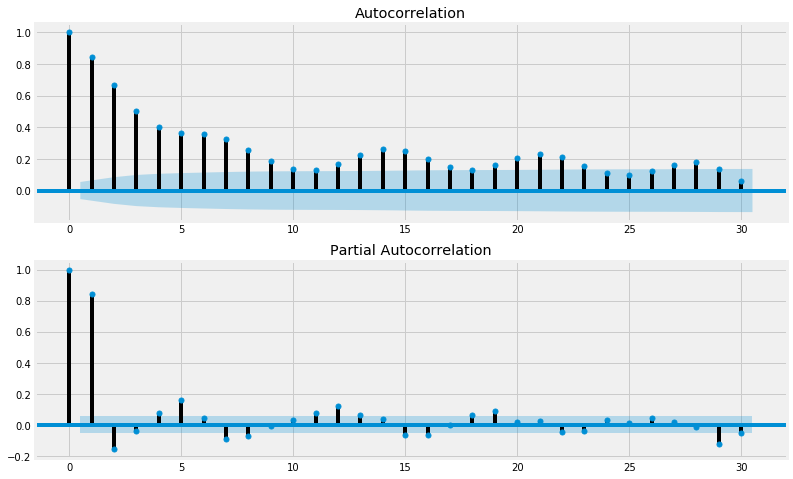

In [71]:
plt.figure()
plt.subplot(211)
plot_acf(df['OCC %'], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(df['OCC %'], ax=plt.gca(), lags = 30)
plt.show();

* If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

* Autocorrelation plot shows most of the lags are either close to 1 or at least greater than the confidence interval, they seem to be statistically significant (stationary).

* Partial autocorrelation after first 2 lags is very low, and only a few lags seem to be statistically significant.

* The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

## Augmented Dickey-Fuller Test

* In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.  A unit root is a feature of random walks that can cause problems in statistical inference involving time series models.
* The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
* Null hypothesis: The time series is not stationary.
* Rejecting the null hypothesis (i.e. a very low p-value) will indicate stationarity.

In [74]:
#Perform Dickey-Fuller test on occupancy:
print ('Results of Dickey-Fuller Test on occupancy:')
dftest = adfuller(df['OCC %'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test on occupancy:
Test Statistic                   -5.132552
p-value                           0.000012
#Lags Used                       18.000000
Number of Observations Used    1291.000000
Critical Value (1%)              -3.435425
Critical Value (5%)              -2.863781
Critical Value (10%)             -2.567963
dtype: float64


In [75]:
#Perform Dickey-Fuller test on revenue:
print ('Results of Dickey-Fuller Test on revenue:')
dftest = adfuller(df['REVENUE'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test on revenue:
Test Statistic                   -2.964111
p-value                           0.038385
#Lags Used                       21.000000
Number of Observations Used    1288.000000
Critical Value (1%)              -3.435437
Critical Value (5%)              -2.863787
Critical Value (10%)             -2.567966
dtype: float64


In [76]:
#Perform Dickey-Fuller test on average rate:
print ('Results of Dickey-Fuller Test on average rate:')
dftest = adfuller(df['AVE RATE'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test on average rate:
Test Statistic                   -4.713914
p-value                           0.000079
#Lags Used                        4.000000
Number of Observations Used    1305.000000
Critical Value (1%)              -3.435371
Critical Value (5%)              -2.863757
Critical Value (10%)             -2.567950
dtype: float64


We can reject the null hypothesis, and the time series for these three variables are stationary.

## Predicting and forecasting Revenue using ARIMA model

In [119]:
df.set_index('DATE', inplace=True)
y = df['REVENUE'].resample('MS').mean()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1009.7569132533758
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1298.6756361369025
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:598.828414587043
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:620.3789958568041


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1276.9698980877388
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:387.1005037227036
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1661.4677190846837
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10121.851806249275
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:581.5266204422986
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:721.3087433933233
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12767.855219950048


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:387.0087363488739
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:854.8504475138545
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1433.7534540357783
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:590.8784177284102
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:611.2358933638305
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2810.0046059311962
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:366.6806275496966
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:833.8260717480932
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3114.0999755700323


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:564.0328691054366
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:613.3479457275184
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3773.587293825756
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:368.0222839599624
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:875.0964980091661
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2975.7294210918462
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:600.1382965285909
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:614.0889185776016


/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1458.1160062182312
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:366.4111978735403
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:854.5831906307761
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:27544633.572175834
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:583.1179455662876
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:614.925068556734
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:7586637.174201547
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:368.947917875355
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:852.5285964903225
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2795.976576961089
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:585.8683408186826
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:595.044576286211
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2658.389712799968
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:349.53421423341376
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:834.7411270202196
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:158856.07359584814
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:565.9657624204514
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:595.9711846909343
ARIMA(1, 

In [120]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2579      0.850     -0.303      0.762      -1.924       1.408
ma.L1         -0.1630      0.835     -0.195      0.845      -1.799       1.473
ar.S.L12      -0.6092      0.342     -1.782      0.075      -1.279       0.061
sigma2      1.065e+07   1.52e-07   7.01e+13      0.000    1.06e+07    1.06e+07


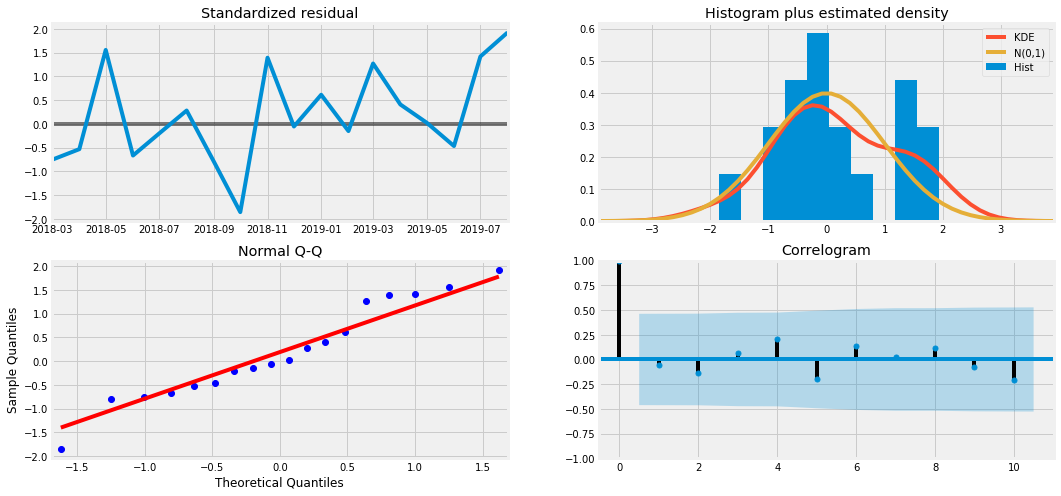

In [121]:
results.plot_diagnostics(figsize=(16, 8))
plt.show();

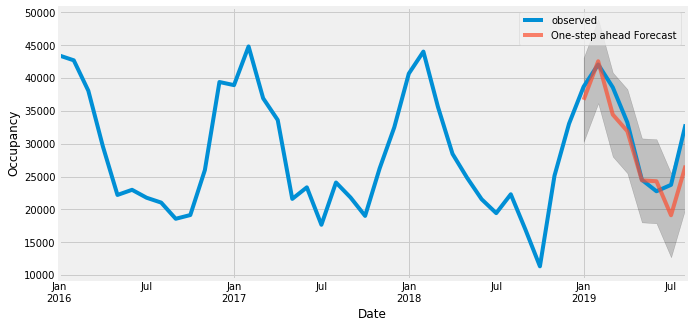

In [123]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Occupancy')
plt.legend()
plt.show();

The ARIMA model forecasts align with the true values very well, showing a downward trend starts from the early 2019 and captured the seasonality toward July and after.

In [126]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]

# Compute the RMSE
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of revenue forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of revenue forecasts is 3289.78


The ARIMA result was not bad.

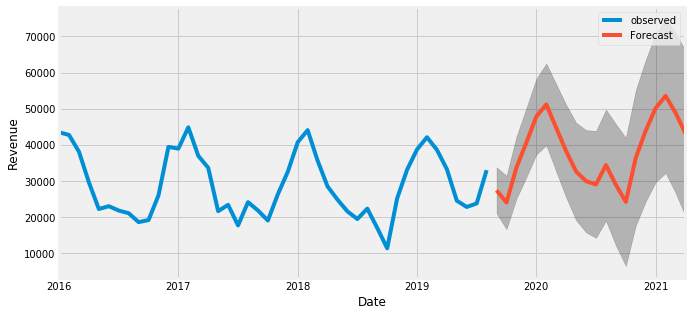

In [131]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(10, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show();

The ARIMA model clearly captured revenue seasonality. As we forecast revenue out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Predicting and forecasting Revenue with Prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 720x360 with 0 Axes>

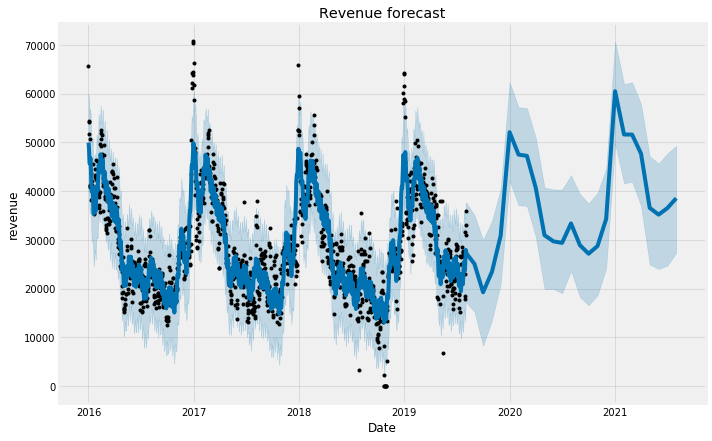

In [157]:
# df.reset_index(inplace=True)
rev = df[['DATE', 'REVENUE']]
rev = rev.rename(columns = {'DATE': 'ds', 'REVENUE': 'y'})
model = Prophet(interval_width=0.95)
model.fit(rev)
forecast = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(forecast)
plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'revenue')
plt.title('Revenue forecast');

In [164]:
metric_df = forecast.set_index('ds')[['yhat']].join(rev.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [166]:
mse = mean_squared_error(metric_df.y, metric_df.yhat)
print('The Root Mean Squared Error of revenue forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of revenue forecasts is 5149.68


In [168]:
import ml_metrics as metrics
metrics.rmse(metric_df.y, metric_df.yhat)

5149.681654028265

Prophet plots the observed values of our revenue time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

As we can see Prophet catches the trends and most of the time gets values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series.

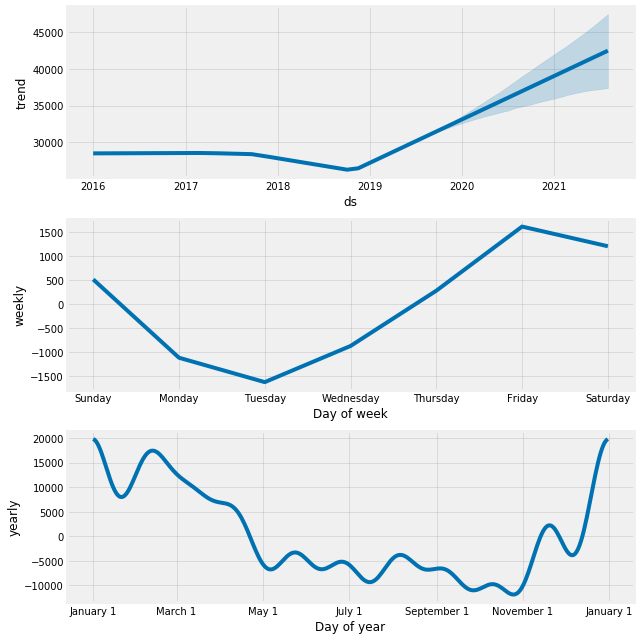

In [143]:
model.plot_components(forecast);

Observations:

* Prophet forecasts that the hotel revenue will likely show an upward trend into the future years.
* Prophet reveals that Tuesday is the lowest day-of-week in revenue, and Friday is the highest day-of-week in revenue.
* Prophet agrees that the worst month in revenue is around October and the best months in revenue are around the end of the year beginning of the following year, plus around February.

## Summary:

* Over the past 4 years, the hotel occupancy started declining since early 2018. And revenue and average rate started dropping at around July 2017.
* 2018 was the worst year in terms of occupany, revenue and average rate. The hotel seems to try to be back on track in 2019. So far so good.
* There is a relative strong seasonaity in this hotel's business. The seasonal changes are pretty uniform. There are outliers and they are likely to occur in the peak season and off-peason season.
* Every year, October is the worst month in terms occupancy and revenue. I guess it is because of hurricane?
* The best months of the year are February, November and December, for occupany. And the best months are January and February for revenue and average rate. This indicates that the hotel slashes rate in order to fill the rooms in November and December to recover from the hurricane quickly.
* The conclusion of hurricane season means tourists will start returning to the region, meaning rates will steadily increase until reaches its peak around February.
* In general, occupancy is higher during the weekend (Fri, Sat and Sun) than during the weekdays.
* When we look at the quarterly change, The Q1 posts stronger daily revenue and rate and Q3 posts a weak daily revenue and rate.
* Around 2017-Q2 had one of the highest occupancy, however, during the same time period, the hotel does not have the highest revenue or rate.
* Around 2018-Q4 had the lowest occupancy while the rate and revenue was not the worst. This indicates 6 days zero revenue affected the occupancy the most.
* By month, we see that Oct is the worst month, by quarter, we realize that Q3 is the worst performed quarter. This indicates that the hotel business recovers quickly after October.
* By day of week, it looks like hotel is likely to generate more revenue on Fridays and less revenue on Tuesdays.
* It seems to me that in order to maintain a higher occupancy, the hotel would slash rate when it needs to.

### Questions:

* Why there were negative and zero revenue in Oct 2018?

* How do you compete with the other hotels in the same market?

* I notice that the hotel is busier over the weekend. What kind of customers stay ove the weekend only? Locals?

* It seems the hotel has been doing well so far compare with the same time period last year. What efforts have you made?

* What revenue channels are the most important for the hotel?

* Do the above observations make sense?